# Feature Correlations with Lifetime

Andrew Weng

9/20/2020

In [110]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import yaml
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

from src.utils import get_label_registry
import src.plotter as plotter

import warnings
warnings.filterwarnings('ignore')

In [111]:
plotter.initialize(plt)
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)
output_path = f"{paths['outputs']}/2022-08-25-manufacturing-features"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Configure globals

In [112]:
# Formation types
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL_CELL = np.array([0, 0, 0])

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

# Load the correlation data

In [116]:
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

path = paths['outputs'] + 'correlation_data.csv'
df = pd.read_csv(path)
df = df[df['cellid'] != 9]

label_registry = get_label_registry()

df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan
df['var_q_1c_c100_c10_mah'] = df['var_q_1c_c100_c10_ah'] * 1000

df_rt = df[df['is_room_temp_aging'] == 1]
df_ht = df[df['is_room_temp_aging'] == 0]

In [117]:
def fetch_label(label_registry, varname):
    
    try:
        label = label_registry[varname][0]
    except:
        label = varname
        
    return label

# Make some single-variable correlation plots

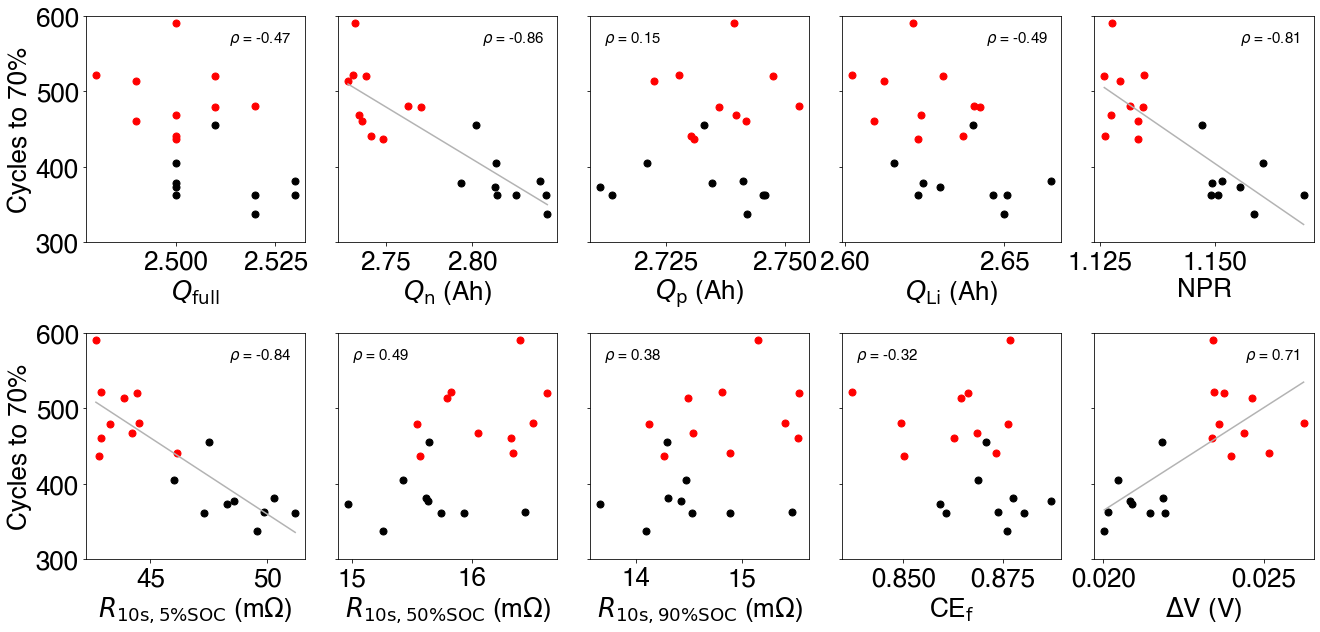

In [118]:
xvar_array = ['esoh_c3_Qfull',
              'esoh_c3_Cn',
              'esoh_c3_Cp',
              'esoh_c3_Cli',
              'esoh_c3_npr',
              'dcr_10s_5_soc_at_c3',
              'dcr_10s_50_soc_at_c3',
              'dcr_10s_90_soc_at_c3',
              'form_coulombic_efficiency',
              'form_6hr_rest_delta_voltage_v',
              ]

xvar_labels = ['$Q_{\mathrm{full}}$',
               '$Q_{\mathrm{n}}$ (Ah)',
               '$Q_{\mathrm{p}}$ (Ah)',
               '$Q_{\mathrm{Li}}$ (Ah)',
               'NPR',
               '$R_{\mathrm{10s, 5\% SOC}}$ (m$\Omega$)',
               '$R_{\mathrm{10s, 50\% SOC}}$ (m$\Omega$)',
               '$R_{\mathrm{10s, 90\% SOC}}$ (m$\Omega$)',
               'CE$_{\mathrm{f}}$',
               '$\Delta$V (V)']

# Also try: 'thickness_mm'
# yvar = 'form_qc_minus_qd_ah'
yvar = 'cycles_to_70_pct'
yvar_array = ['cycles_to_70_pct',
              'dcr_10s_50_soc_at_c365']

df = df_ht

gridspec = dict(wspace=0.15, width_ratios=[1, 1, 1, 1, 1], 
                hspace=0.40, height_ratios=[1, 1])

fig, axs = plt.subplots(nrows=2, ncols=5,
                    gridspec_kw=gridspec,
                    figsize=(22, 10))

# Loop over x-variables
for xvar, xvar_label, ax in zip(xvar_array, xvar_labels, axs.flatten()):

    model = LinearRegression()
    
    # Add path for derived features that wasn't defined in the initial dataset
    if xvar == 'esoh_c3_npr':
        x = 1 + df['esoh_c3_neg_excess'].values / df['esoh_c3_Qfull'].values
    elif xvar == 'esoh_c3_Cli':
        x = df['esoh_c3_n_li'].values / 3600 * 96500
    elif xvar == 'dcr_10s_5_soc_at_c3':
        x = df[xvar].values * 1000
    elif xvar == 'dcr_10s_50_soc_at_c3':
        x = df[xvar].values * 1000
    elif xvar == 'dcr_10s_90_soc_at_c3':
        x = df[xvar].values * 1000
    else:
        x = df[xvar].values

    y = df[yvar].values
    idx_to_keep = ~np.isnan(x)
    x = x[idx_to_keep]
    y = y[idx_to_keep]

    corr, _ = pearsonr(x, y)
    model.fit(x.reshape(-1, 1), y)
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = model.predict(x_fit.reshape(-1, 1))
    
    idx_base = np.where(df['is_baseline_formation'] == True)[0]
    idx_fast = np.where(df['is_baseline_formation'] == False)[0]

    ax.plot(x[idx_fast], df[yvar].iloc[idx_fast], 
                linestyle='None', marker='o', markersize=7,
                color=COLOR_FAST_HT, label='')

    ax.plot(x[idx_base], df[yvar].iloc[idx_base], 
                linestyle='None', marker='o', markersize=7,
                color=COLOR_BASE, label='')

    if corr**2 > 0.5:
        ax.plot(x_fit, y_fit, color=COLOR_REF, label='')
        
    ax.plot(np.nan, np.nan, label=rf'$\rho$ = {corr:.2f}',
                        marker='None', linestyle='None')

    leg = ax.legend(frameon=False,
                            handletextpad=0, handlelength=0, fontsize=15)

#         plt.xlim(label_registry[xvar][1])
    ax.set_xlim((None, None))
    ax.set_xlabel(xvar_label)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_ylim((300, 600))

axs[0, 0].set_ylabel(fetch_label(label_registry, yvar));
axs[1, 0].set_ylabel(fetch_label(label_registry, yvar));
axs[0, 0].set_yticklabels([300, 400, 500, 600]);
axs[1, 0].set_yticklabels([300, 400, 500, 600]);

